In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.contrib.learn.python.learn.datasets.mnist import read_data_sets
from visualization import *

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
np.random.seed(0)
tf.set_random_seed(0)

## Data

In [2]:
mnist = read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
n_samples = mnist.train.num_examples
print ('number of sumples:', n_samples)

number of sumples: 55000


## some model utils

In [4]:
# feed_forward model structure
from keras.layers import Input, Dense
from keras.models import Sequential, Model

def feed_forward(input_dim, layers):
    """
    Return a keras model object.
    input_dim: the orginial input dims
    layers: a list specifying the dims of each layer
    """
    model = Sequential()
    for i in range(len(layers)):
        if i == 0:
            model.add(Dense(layers[i], input_shape=(input_dim,), activation='relu'))
        else:
            model.add(Dense(layers[i], activation='relu'))
    return model

Using TensorFlow backend.


## VAE

In [6]:
from tensorflow.contrib.distributions import Normal, Bernoulli

class VAE(object):
    def __init__(self, batch_size, input_dim, latent_dim, lr=0.001):
        self.batch_size = batch_size
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.lr = lr
        self._initialize()

    def _initialize(self):
        # placeholder for input data
        self.x = tf.placeholder(tf.float32, [None, self.input_dim])
        # create network
        self.create_network()
        self.obj_fun()
        # init tensorflow graph
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())

    def create_network(self):
        self.z_mean, self.z_log_std = self.encoder_network(self.x)
        self.z = self.sampling(self.z_mean, self.z_log_std)
        self.x_decoded = self.decoder_network(self.z)

    def encoder_network(self, x):
        """
        Takes in x, and return parameters of latents z.
        """
        # two intermediate layer
        layers = [32, 32]
        h = feed_forward(self.input_dim, layers)(x)
        z_mean = Dense(self.latent_dim)(h)
        z_log_std = Dense(self.latent_dim)(h)
        return z_mean, z_log_std

    def sampling(self, z_mean, z_log_std):
        """
        Takes in the parameters for z, and return samples.
        """
        epsilon = tf.random_normal(shape=(batch_size, latent_dim), mean=0.,
                                   stddev=1.0)
        z = z_mean + tf.exp(z_log_std) * epsilon
        return z

    def decoder_network(self, z):
        """
        Take latents, and return reconstruction.
        """
        layers = [32, 32]
        h = feed_forward(self.latent_dim, layers)(z)
        x_recon = Dense(self.input_dim, activation='sigmoid')(h)
        x_recon = tf.clip_by_value(x_recon, 0.000001, 0.999999)
        return x_recon

    def obj_fun(self):
        """
        calculate ELBO
        """
        log_px_gz = tf.reduce_sum(Bernoulli(probs=self.x_decoded).log_prob(self.x), axis=1)
        log_p_z = tf.reduce_sum(Normal(0.0, 1.0).log_prob(self.z), axis=1)
        log_q_z_gx = tf.reduce_sum(Normal(self.z_mean, tf.exp(self.z_log_std)).log_prob(self.z), axis=1)
        self.obj = tf.reduce_sum(log_px_gz + log_p_z - log_q_z_gx) / self.batch_size
        self.opt = tf.train.AdamOptimizer(learning_rate=self.lr).minimize(-self.obj)

    def minbatch_fit(self, X):
        opt, obj = self.sess.run((self.opt, self.obj), feed_dict={self.x: X})
        return obj

    def latent_space_visulization(self, X):
        return self.sess.run(self.z_mean, feed_dict={self.x: X})

    def recons(self, X):
        return self.sess.run(self.x_decoded, feed_dict={self.x: X})

    def generating_samples(self, z_mu):
        return self.sess.run(self.x_decoded, feed_dict={self.z: z_mu})

In [7]:
batch_size=100
input_dim = 784
latent_dim = 2
lr = 0.001

va = VAE(batch_size, input_dim, latent_dim, lr)

## Training

In [8]:
training_epochs=5
printing = 1

In [9]:
x_sample_m, y_labels_m = mnist.test.next_batch(3000)
cost_plotting=[]
laten_space=[]
reconstructed=[]
for epoch in range(training_epochs):
    avg_cost = 0.
    total_batch = int(n_samples / batch_size)
    for i in range(total_batch):
        batch_xs, _ = mnist.train.next_batch(batch_size)
        cost = va.minbatch_fit(batch_xs)
        avg_cost += cost / n_samples * batch_size
        
    if epoch % printing == 0:
        cost_plotting.append(avg_cost)
        laten_space.append(va.latent_space_visulization(x_sample_m))
        reconstructed.append(va.recons(x_sample_m[:100]))
        print("Epoch:", '%02d' % (epoch+1), "Average_cost=", "{:.9f}".format(avg_cost))

Epoch: 01 Average_cost= -224.647295810
Epoch: 02 Average_cost= -184.553701505
Epoch: 03 Average_cost= -177.157721835
Epoch: 04 Average_cost= -172.912083934
Epoch: 05 Average_cost= -169.539027377


## Let's look at the results.

In [10]:
visu=Visualization(total_epoch=training_epochs, batch_size=batch_size, printing=printing)

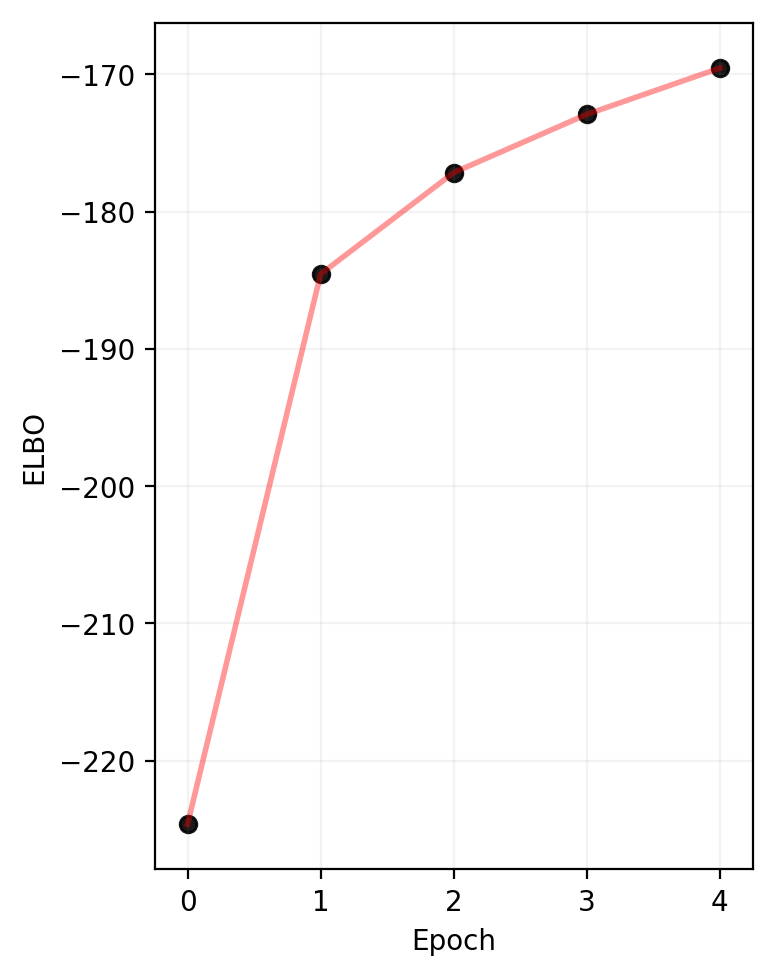

In [11]:
#train cost
visu.plotting_cost(cost_plotting)

In [12]:
#latens space visualization our training
visu.plotting_latent_space(laten_space, y_labels_m)

In [13]:
# reconstruction visualization
visu.plotting_training_visual(reconstructed, x_sample_m[:100])

Loading BokehJS ...

In [14]:
#generation of new data using custum mean
visu.plott_gener_sample_from_dist(-4, 4, -4, 4)

AttributeError: 'int' object has no attribute 'generating_samples'